# K-Means Computational Baseline + Comparsion with Human Reconstruction
Author: Joshua (Hyun Jo) Jang

In [ ]:
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import math

from wcs_helper_functions import *

### We load CIELAB colour patch data, and compute the median number of labels used (k) for each language.

In [5]:
np.set_printoptions(suppress=True)

# load CIELAB data
cielabCoord = readClabData('./WCS_data_core/cnum-vhcm-lab-new.txt')
lab_data = np.array(list(cielabCoord.values()))
print(lab_data.shape)

# normalise CIELAB values to roughly [-1,1]
lab = lab_data.astype(np.float32)
lab[:, 0] = lab[:, 0] / 50.0 - 1.0
lab[:, 1] = lab[:, 1] / 128.0
lab[:, 2] = lab[:, 2] / 128.0

# compute median k per language
namingData = readNamingData('./WCS_data_core/term.txt')
language_k = []
for lang in namingData.values():
    ks = []
    for speaker in lang.values():
        ks.append(len(set(speaker.values())))
    language_k.append(int(np.median(np.array(ks))))

# find the minimum and maximum k across all languages
min_k, max_k = min(language_k), max(language_k)
print(f"k range from language data: {min_k} to {max_k}")

(330, 3)
k range from language data: 3 to 17


### For each k value (3 to 17), we run 50 trials of randomly initialised K-Means clustering of the WCS CIELAB patches, and record the reconstruction MSE for each and every trial.

In [6]:
# K-means clustering
ks_to_try = range(min_k, max_k + 1)

# prepare to plot clustering results per k, 3 columns
num_k = len(ks_to_try)
cols = min(3, num_k)
rows = math.ceil(num_k / cols)

results = []

# for each k, try 50 runs of K-Means optimisation, pick the best one.
for i, k in enumerate(ks_to_try):
    print(f"\nOptimising KMeans with k = {k}")

    k_results = []
    # we used to use n_init=50, but to keep track of all non-best results, we manually loop
    for iter in range(50):
        # use a helper class which minimises within-cluster SSE
        kmeans = KMeans(n_clusters=k, n_init=1, random_state=iter)
        kmeans.fit(lab)

        # optimised cluster centres/prototypes
        centres = kmeans.cluster_centers_

        # encode: get cluster index for given x
        labels = kmeans.labels_

        # reconstruction/decode: take centre
        recon = centres[labels]

        # per-point squared error and MSE
        se = np.sum((lab - recon) ** 2, axis=1)
        mse = float(np.mean(se))

        k_results.append((mse, centres, labels))

    # find best run (minimum MSE) over the 50 trials
    best_index = min(range(len(k_results)), key=lambda j: k_results[j][0])
    best_mse, best_centres, best_labels = k_results[best_index]

    print(f"Best Reconstruction MSE of 50 Trials: {best_mse:.6f}")
    results.append(k_results)


Optimising KMeans with k = 3
Best Reconstruction MSE of 50 Trials: 0.127714

Optimising KMeans with k = 4
Best Reconstruction MSE of 50 Trials: 0.103746

Optimising KMeans with k = 5
Best Reconstruction MSE of 50 Trials: 0.085147

Optimising KMeans with k = 6
Best Reconstruction MSE of 50 Trials: 0.073538

Optimising KMeans with k = 7
Best Reconstruction MSE of 50 Trials: 0.063769

Optimising KMeans with k = 8
Best Reconstruction MSE of 50 Trials: 0.057409

Optimising KMeans with k = 9
Best Reconstruction MSE of 50 Trials: 0.051540

Optimising KMeans with k = 10
Best Reconstruction MSE of 50 Trials: 0.047927

Optimising KMeans with k = 11
Best Reconstruction MSE of 50 Trials: 0.043874

Optimising KMeans with k = 12
Best Reconstruction MSE of 50 Trials: 0.040590

Optimising KMeans with k = 13
Best Reconstruction MSE of 50 Trials: 0.037531

Optimising KMeans with k = 14
Best Reconstruction MSE of 50 Trials: 0.035023

Optimising KMeans with k = 15
Best Reconstruction MSE of 50 Trials: 0.

### We now visualise the best (lowest MSE) clustering results for each k

In [7]:
# simple 3D cluster visualisation helper function
def visualise_clusters(lab_points, centres, labels, mse, k, ax):
    ax.scatter(
        lab_points[:, 0],
        lab_points[:, 1],
        lab_points[:, 2],
        c=labels,
        cmap='tab20',
        s=20, alpha=0.7
    )

    # plot cluster centres with label
    ax.scatter(
        centres[:, 0],
        centres[:, 1],
        centres[:, 2],
        c='black',
        s=120, marker='x',
        label="Cluster centres"
    )

    ax.set_title(f"k = {k} Clusters (MSE = {mse:.6f})")
    ax.set_xlabel("L* (normalized)")
    ax.set_ylabel("a* (normalized)")
    ax.set_zlabel("b* (normalized)")

    # add legend
    ax.legend()

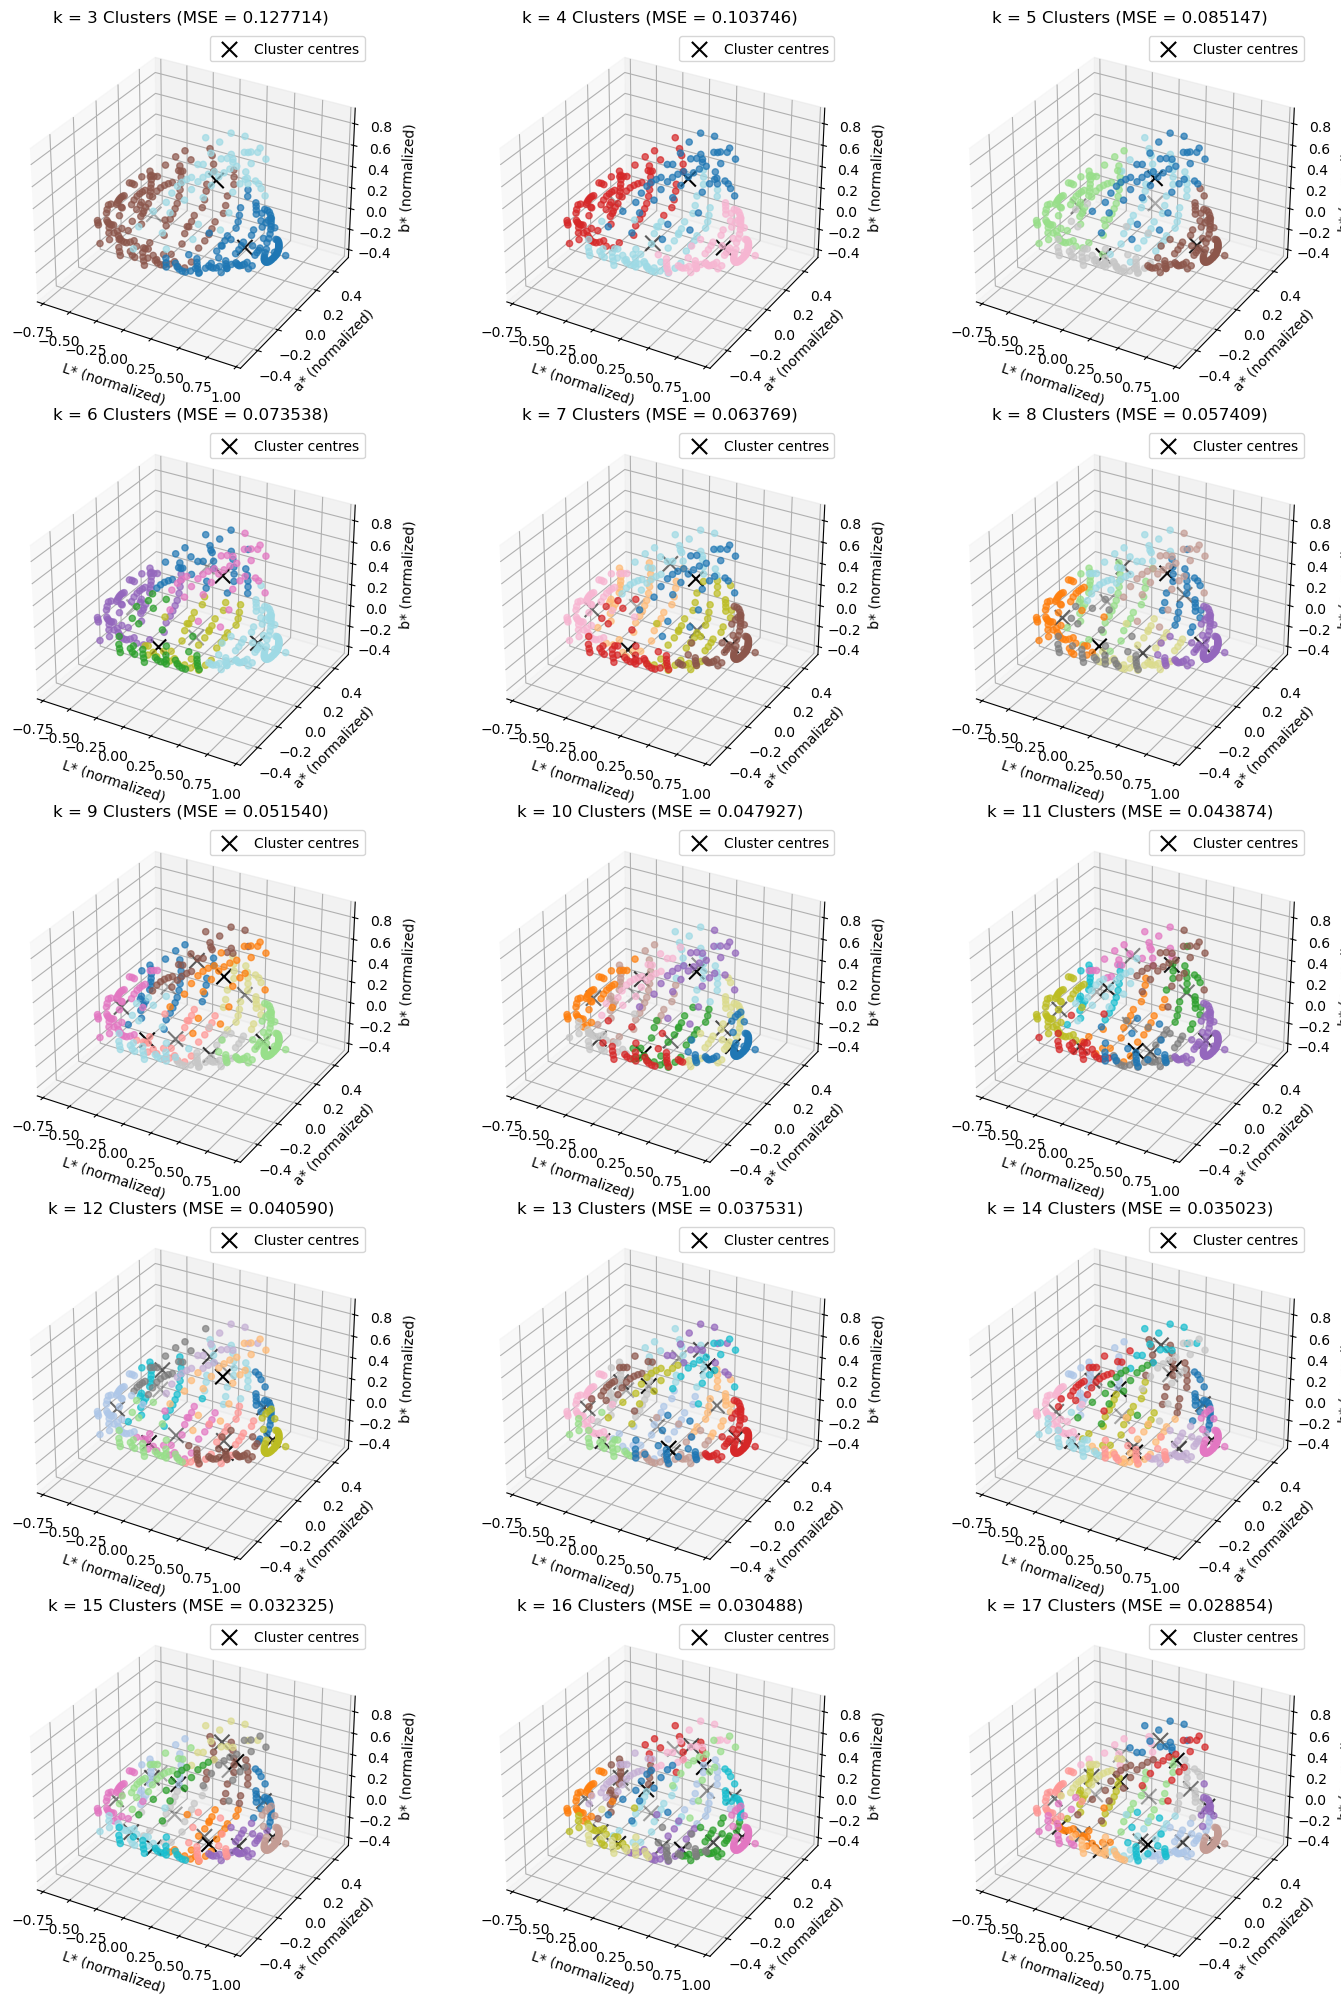

In [8]:
# for each k, plot the best k-means clustering results
fig_clusters = plt.figure(figsize=(5 * cols, 4 * rows))
axes = [fig_clusters.add_subplot(rows, cols, i + 1, projection='3d') for i in range(num_k)]

for i, k in enumerate(ks_to_try):
    # collect all 50 MSEs for this k
    mses = [t[0] for t in results[i]]
    best_index = int(np.argmin(mses))
    best_mse, best_centres, best_labels = results[i][best_index]

    # visualise this best result
    visualise_clusters(lab, best_centres, best_labels, best_mse, k, axes[i])

fig_clusters.tight_layout()
plt.show()

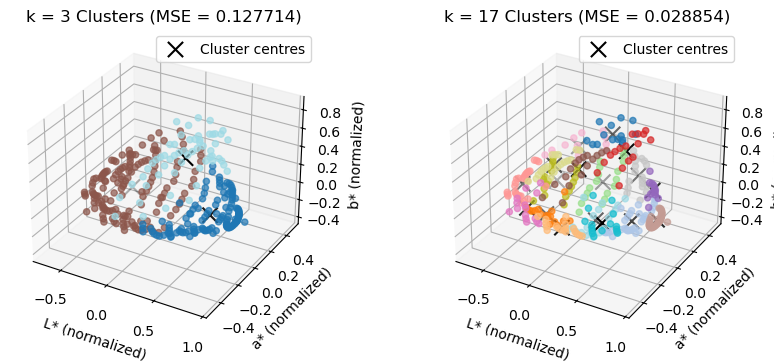

In [9]:
# compact plot just for the first and last k values, for the report writeup
fig_clusters = plt.figure(figsize=(5 * 2, 4))
axes = [fig_clusters.add_subplot(1, 2, i + 1, projection='3d') for i in range(2)]

mses_first = [t[0] for t in results[0]]
best_index_first = int(np.argmin(mses_first))
mse_first, centres_first, labels_first = results[0][best_index_first]

mses_last = [t[0] for t in results[-1]]
best_index_last = int(np.argmin(mses_last))
mse_last, centres_last, labels_last = results[-1][best_index_last]

visualise_clusters(lab, centres_first, labels_first, mse_first, ks_to_try[0], axes[0])
visualise_clusters(lab, centres_last, labels_last, mse_last, ks_to_try[-1], axes[1])


### We plot the MSE progression as k increases. All 50 trials are shown for each k.

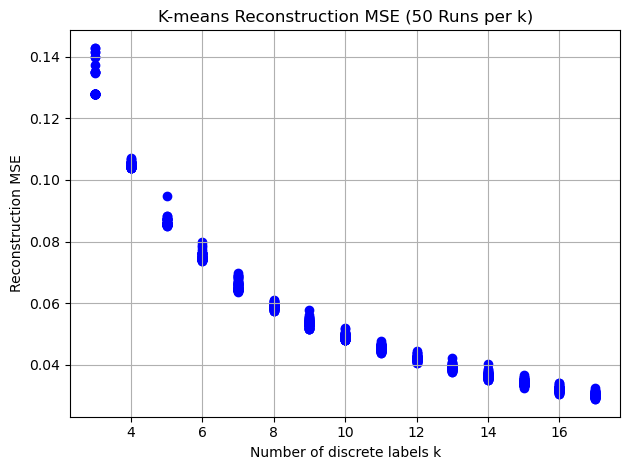

In [19]:
# also plot how reconstruction MSE decreases as k increases (bottleneck gets larger)
# for each k, plot all 50 MSEs as scatter points
for i, k in enumerate(ks_to_try):
    mses = [t[0] for t in results[i]]
    plt.scatter([k] * len(mses), mses, marker="o", color="blue")

plt.xlabel("Number of discrete labels k")
plt.ylabel("Reconstruction MSE")
plt.title("K-means Reconstruction MSE (50 Runs per k)")
plt.grid(True)
plt.tight_layout()
plt.show()

### We load human reconstruction results (we only use wcs_per_speaker_mse.csv) from Nazafarin's code, and plot them alongside our K-Means results. Note that these are MEDIANS for each language.

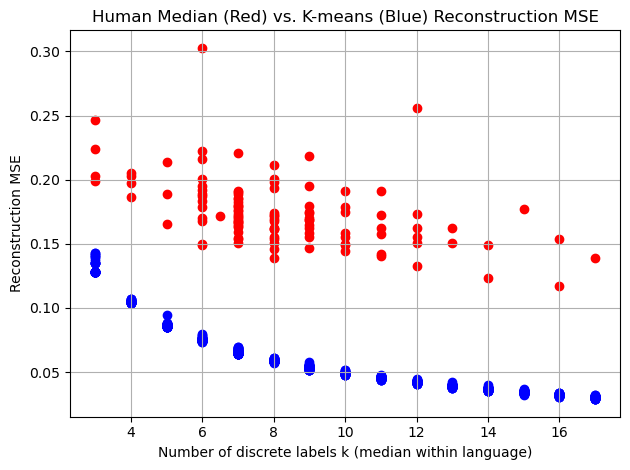

In [23]:
df = pd.read_csv("./outputs/wcs_per_speaker_mse.csv")

language_medians = df.groupby("language_id")[["k_terms", "mse_cielab"]].median().to_numpy()

for i, k in enumerate(ks_to_try):
    mses = [t[0] for t in results[i]]
    plt.scatter([k] * len(mses), mses, marker="o", color="blue")
plt.scatter(language_medians[:, 0], language_medians[:, 1], marker="o", color="red")
plt.xlabel("Number of discrete labels k (median within language)")
plt.ylabel("Reconstruction MSE")
plt.title("Human Median (Red) vs. K-means (Blue) Reconstruction MSE")
plt.grid(True)
plt.tight_layout()
plt.show()

### Now, we plot the BEST results for each language.

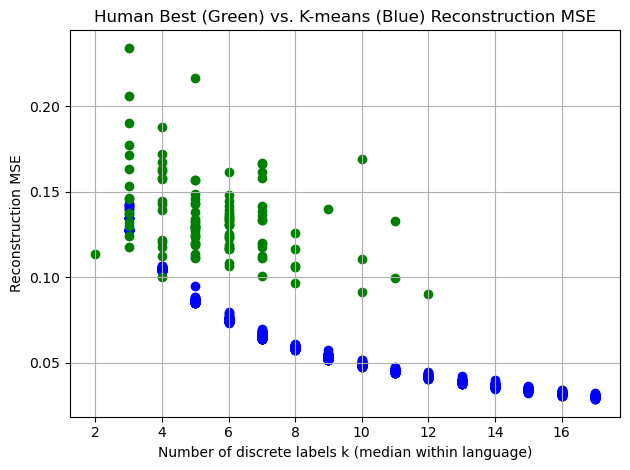

In [24]:
language_best = df.groupby("language_id")[["k_terms", "mse_cielab"]].min().to_numpy()

for i, k in enumerate(ks_to_try):
    mses = [t[0] for t in results[i]]
    plt.scatter([k] * len(mses), mses, marker="o", color="blue")
plt.scatter(language_best[:, 0], language_best[:, 1], marker="o", color="green")
plt.xlabel("Number of discrete labels k (median within language)")
plt.ylabel("Reconstruction MSE")
plt.title("Human Best (Green) vs. K-means (Blue) Reconstruction MSE")
plt.grid(True)
plt.tight_layout()
plt.show()